# DecisionTree

In this notebook, we will try to use Decision Tree

### Load and prepare the dataset

In [23]:
from preprocess_data import get_HITL, clean_HITL, prepare_HTIL_network_dataset, remove_network_contextual_columns

from mlsecu.data_exploration_utils import (
    get_column_names,
    get_nb_of_dimensions,
    get_nb_of_rows,
    get_object_column_names,
    get_number_column_names,
)
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_preparation_utils import (
    get_one_hot_encoded_dataframe,
    remove_nan_through_mean_imputation,
)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    balanced_accuracy_score,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

BASE_PATH = "../../data/"
random_state = 42

In [24]:
hitl_dict = get_HITL("../../data/HardwareInTheLoop/", small=True)
df_network, df_physical = clean_HITL(hitl_dict) # Clean-up helper function

print("Network dataset shape: ", df_network.shape)
print("Physical dataset shape: ", df_physical.shape)

Network dataset shape:  (243065, 17)
Physical dataset shape:  (9206, 44)


In [26]:
df_network_prepared, df_network_labels = prepare_HTIL_network_dataset(df_network)
df_network_prepared.head()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst,mac_s_00:0c:29:47:8c:22,mac_s_00:80:f4:03:fb:12,mac_s_0a:fe:ec:47:74:fb,...,modbus_response_[985],modbus_response_[988],modbus_response_[98],modbus_response_[991],modbus_response_[993],modbus_response_[994],modbus_response_[995],modbus_response_[999],modbus_response_[99],modbus_response_[9]
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_network_labels.head()

,label_n,label,attack,new_labels
0,0,normal,1,3
1,0,normal,1,3
2,0,normal,1,3
3,0,normal,1,3
4,0,normal,1,3


## Train Decision Tree model

Split the dataset into training and test sets

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_network_prepared, df_network_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194452, 1986), (48613, 1986), (194452, 2), (48613, 2))

Define the model with empirical parameters

In [29]:
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state
}

clf = DecisionTreeClassifier(**params)

In [30]:
pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

In [31]:
preds = pipeline.predict(X_test)

In [32]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Precision: ", precision_score(y_test["new_labels"], preds.round(), average="macro"))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.9329397486269105
Precision:  0.7819866535010626
Recall:  0.5697351629559801
F1:  0.6212123392376323
MCC:  0.8441165543717744
Balanced accuracy:  0.5697351629559801


/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/MLSECU/ML-SECU2024/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

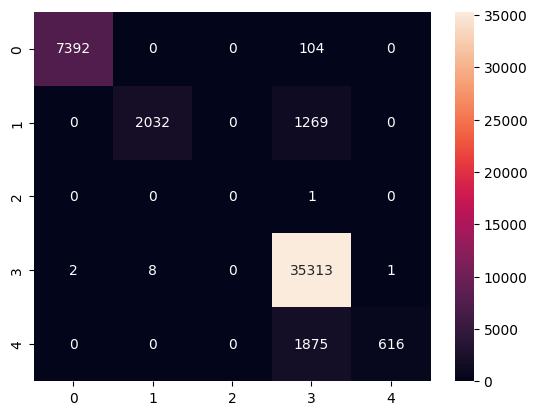

In [33]:
confusion_matrix(y_test["new_labels"], preds.round())
sns.heatmap(confusion_matrix(y_test["new_labels"], preds.round()), annot=True, fmt="d")

Let's see which feature is the most important

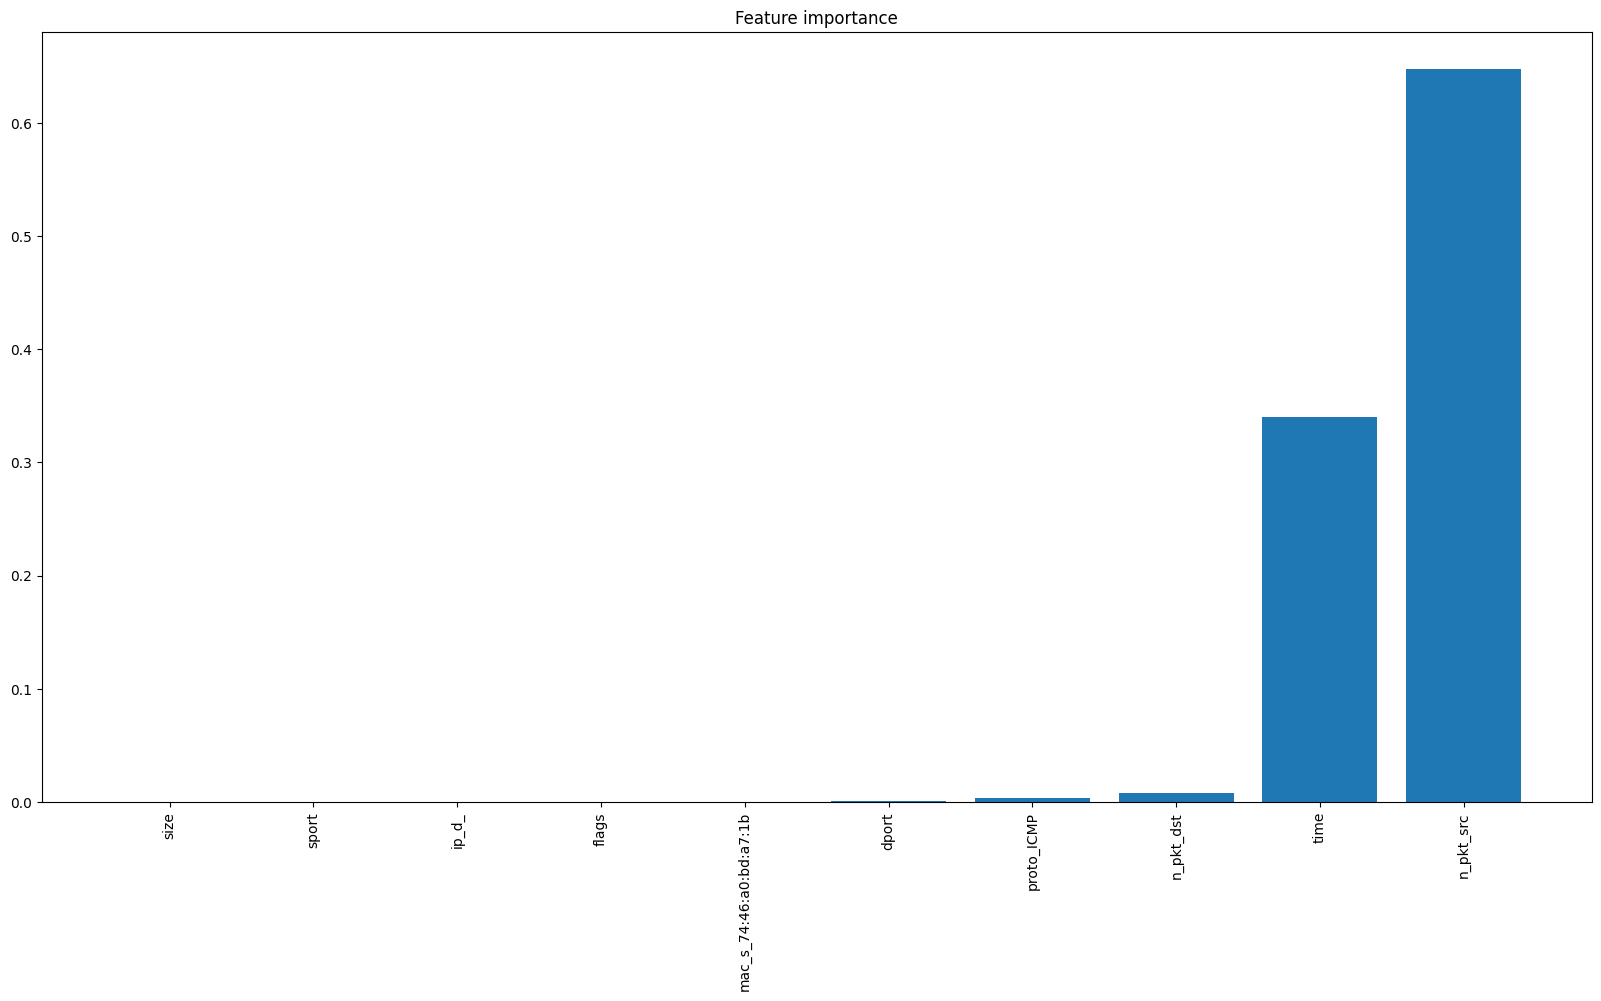

In [34]:
# plot feature importance
importance = clf.feature_importances_
# keep 10 most important features
idx = np.argsort(importance)[-10:]
importance = importance[idx]
# plot feature importance
plt.figure(figsize=(20, 10))
plt.title("Feature importance")
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], X_train.columns[idx], rotation='vertical')
plt.show()

### Without contextual features

In [35]:
df_network_no_context = remove_network_contextual_columns(df_network)
df_network_no_context

,sport,dport,proto,flags,size,modbus_fn,n_pkt_src,n_pkt_dst,label_n,label,attack
0,56666.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,1
1,502.0,56666.0,Modbus,11000.0,64,Read Coils Response,15.0,50.0,0,normal,1
2,56668.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,1
3,502.0,56668.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,0,normal,1
4,502.0,56666.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,0,normal,1
...,...,...,...,...,...,...,...,...,...,...,...
243060,61516.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,0
243061,61516.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,0
243062,61517.0,502.0,Modbus,11000.0,66,Read Holding Registers,51.0,14.0,0,normal,0
243063,61515.0,502.0,Modbus,11000.0,66,Read Holding Registers,47.0,14.0,0,normal,0


In [36]:
df_network_prepared, df_network_labels = prepare_HTIL_network_dataset(df_network_no_context)
df_network_prepared.head()

,sport,dport,flags,size,n_pkt_src,n_pkt_dst,proto_ARP,proto_ICMP,proto_IP,proto_Modbus,proto_TCP,modbus_fn_,modbus_fn_Read Coils Request,modbus_fn_Read Coils Response,modbus_fn_Read Holding Registers,modbus_fn_Read Holding Registers Response
0,56666.0,502.0,11000.0,66,50.0,15.0,0,0,0,1,0,0,0,0,1,0
1,502.0,56666.0,11000.0,64,15.0,50.0,0,0,0,1,0,0,0,1,0,0
2,56668.0,502.0,11000.0,66,50.0,15.0,0,0,0,1,0,0,0,0,1,0
3,502.0,56668.0,11000.0,65,15.0,50.0,0,0,0,1,0,0,0,0,0,1
4,502.0,56666.0,11000.0,65,15.0,50.0,0,0,0,1,0,0,0,0,0,1


In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_network_prepared, df_network_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194452, 16), (48613, 16), (194452, 2), (48613, 2))

In [38]:
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state
}

clf = DecisionTreeClassifier(**params)

In [39]:
pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

In [40]:
preds = pipeline.predict(X_test)

In [41]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Precision: ", precision_score(y_test["new_labels"], preds.round(), average="macro"))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.8776047559294838
Precision:  0.4711248545109347
Recall:  0.39588704410421466
F1:  0.38245737832039567
MCC:  0.7060071605653443
Balanced accuracy:  0.39588704410421466


/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/MLSECU/ML-SECU2024/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

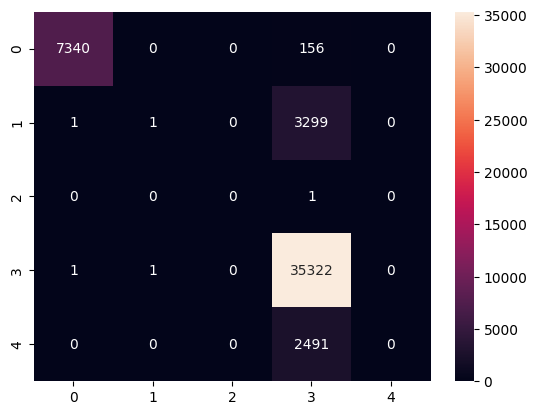

In [42]:
confusion_matrix(y_test["new_labels"], preds.round())
sns.heatmap(confusion_matrix(y_test["new_labels"], preds.round()), annot=True, fmt="d")

In [43]:
df_network["label"].astype("category").cat.codes.value_counts()

3    176087
0     37665
1     16841
4     12469
2         3
Name: count, dtype: int64

As we could expect, the classifier struggles more without the time information. This is still a good thing to remove it, because we don't want to rely on it. We need to be able to detect an attack even if it happens at a different time

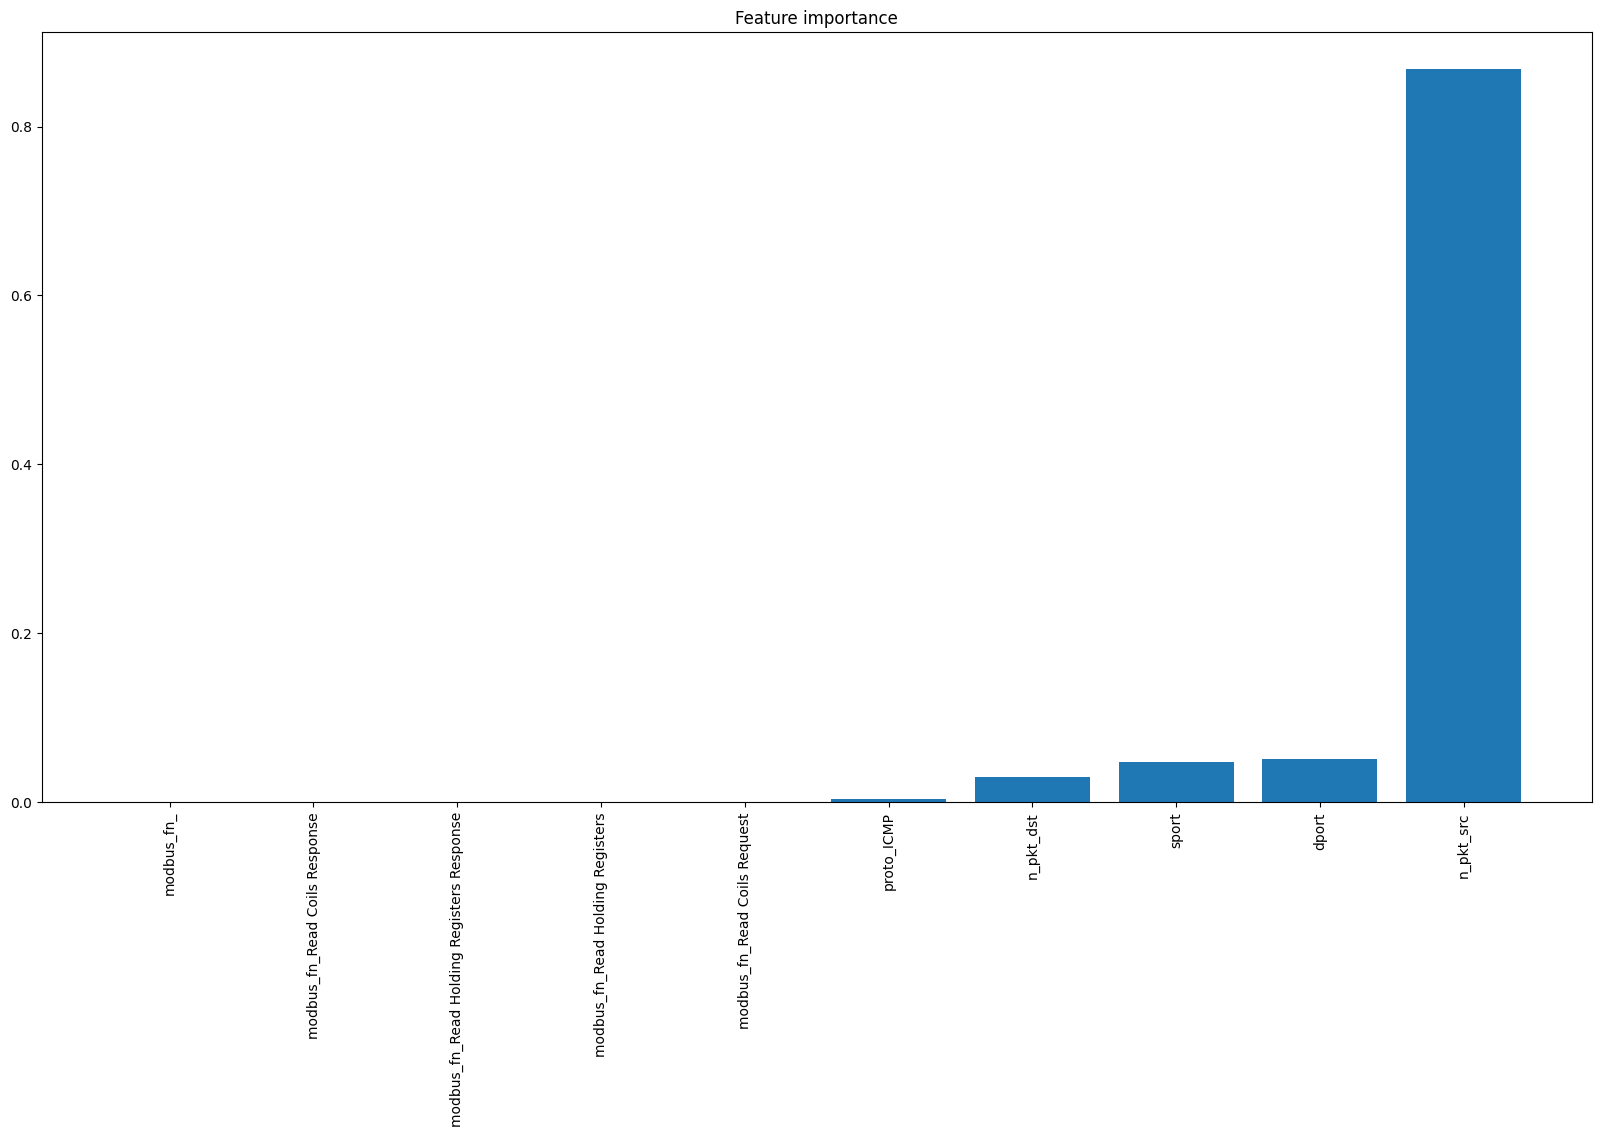

In [44]:
# plot feature importance
importance = clf.feature_importances_
# keep 10 most important features
idx = np.argsort(importance)[-10:]
importance = importance[idx]
# plot feature importance
plt.figure(figsize=(20, 10))
plt.title("Feature importance")
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], X_train.columns[idx], rotation='vertical')
plt.show()